In [1]:
import os
import re
import json
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

max_len = 384
configuration = BertConfig()
data_csv = "ner_dataset.csv"

In [2]:
tf.__version__

'2.4.1'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [5]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

!wget https://raw.githubusercontent.com/dakshitagrawal97/TextToNarrate/master/ner_dataset.csv

In [69]:
loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy",
)
def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 17))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def create_model(num_tags):
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## NER Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]
    embedding = layers.Dropout(0.3)(embedding)
    tag_logits = layers.Dense(num_tags+1, activation='softmax')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(lr=3e-5)
    model.compile(optimizer=optimizer, loss=masked_ce_loss, metrics=['accuracy'])
    return model

In [70]:
def process_csv(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")
    enc_tag = preprocessing.LabelEncoder()
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])
    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, tag, enc_tag


def create_inputs_targets(data_csv):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "tags": []
    }
    sentences, tags, tag_encoder = process_csv(data_csv)
    
    for sentence, tag in zip(sentences, tags):
        input_ids = []
        target_tags = []
        for idx, word in enumerate(sentence):
            ids = tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids.ids)
            num_tokens = len(ids)
            target_tags.extend([tag[idx]] * num_tokens)
        
        
        # Pad truncate
        input_ids = input_ids[:max_len - 2]
        target_tags = target_tags[:max_len - 2]

        input_ids = [101] + input_ids + [102]
        target_tags = [16] + target_tags + [16]
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_tags = target_tags + ([17] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        dataset_dict["tags"].append(target_tags)
        assert len(target_tags) == max_len, f'{len(input_ids)}, {len(target_tags)}'
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = dataset_dict["tags"]
    return x, y, tag_encoder, dataset_dict

In [71]:
_,_,_, dataset_dict = create_inputs_targets(data_csv)

In [72]:
dataset_dict["tags"]

array([[16, 16, 16, ..., 17, 17, 17],
       [16,  3, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17],
       ...,
       [16, 16,  2, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17],
       [16, 16,  5, ..., 17, 17, 17]])

In [73]:
num_tags = pd.read_csv(data_csv, encoding="latin-1")["Tag"].nunique()

model = create_model(num_tags)
    
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_3 (TFBertModel)   TFBaseModelOutputWit 109482240   input_10[0][0]                   
                                                                 input_12[0][0]             

In [74]:
output = model.layers[-1]

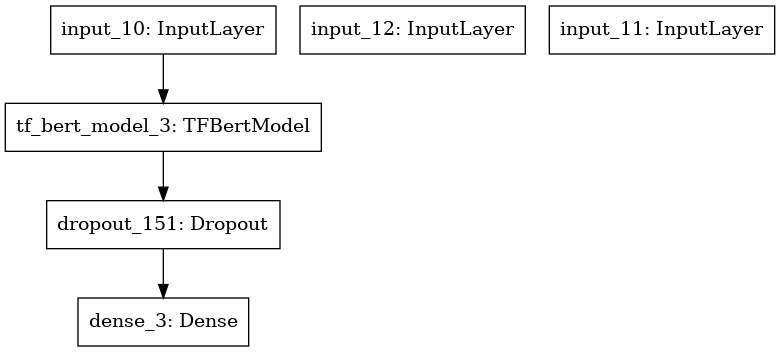

In [75]:

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [76]:
x_train, y_train, tag_encoder, _ = create_inputs_targets(data_csv)

bs = 16


In [ ]:
model.fit(
    x_train,
    keras.utils.to_categorical(y_train[:]),
    epochs=1,
    verbose=1,
    batch_size=16,
    validation_split=0.1
)

1194/2698 [============>.................] - ETA: 7:43 - loss: 0.0924 - accuracy: 0.9782

In [32]:
y_train.shape

(47959, 384)

In [45]:
y_train[0]

array([16, 16, 16, 16, 16, 16, 16,  2, 16, 16, 16, 16, 16,  2, 16, 16, 16,
       16, 16,  3, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17

In [28]:
def create_test_input_from_text(texts):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": []
    }
    for sentence in texts:
        input_ids = []
        for idx, word in enumerate(sentence.split()):
            ids = tokenizer.encode(word, add_special_tokens=False)
            input_ids.extend(ids.ids)
            num_tokens = len(ids)
            
        # Pad and create attention masks.
        # Skip if truncation is needed
        input_ids = input_ids[:max_len - 2]

        input_ids = [101] + input_ids + [102]
        n_tokens = len(input_ids)
        token_type_ids = [0] * len(input_ids)
        attention_mask = [1] * len(input_ids)
        padding_len = max_len - len(input_ids)

        input_ids = input_ids + ([0] * padding_len)
        attention_mask = attention_mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        
        dataset_dict["input_ids"].append(input_ids)
        dataset_dict["token_type_ids"].append(token_type_ids)
        dataset_dict["attention_mask"].append(attention_mask)
        
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    return x, n_tokens

test_inputs = ["Jack live in Taipei"]
x_test, n_tokens = create_test_input_from_text(test_inputs)
print('input tokens')
print(x_test[0][0][:n_tokens])
pred_test = model.predict(x_test)
pred_tags = np.argmax(pred_test,2)[0][:n_tokens]  # ignore predictions of padding tokens

# create dictionary of tags and and their indexes
le_dict = dict(zip(tag_encoder.transform(tag_encoder.classes_), tag_encoder.classes_))
print('predicted tags')
print([le_dict.get(_, '[pad]') for _ in pred_tags])

input tokens
[  101  2990  2444  1999 14004   102]
predicted tags
['O', 'B-per', 'O', 'O', 'B-geo', 'O']


In [ ]:
pred_test.shape

(1, 384, 18)

In [ ]:
a = pred_test[0]

In [ ]:
np.argmax(a[0])

16

In [ ]:
np.argmax(pred_test,2)[0]

array([16,  6, 16, 16,  2, 16, 16, 16, 16, 16, 16, 16,  6,  6, 16, 16,  6,
        6, 16, 16, 16,  6,  6, 16,  6,  6,  6,  6,  6, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16,  6,  6,  6, 16, 16, 16, 16, 16,  6,  6, 16,
        6,  6,  6,  6,  6,  6, 16, 16, 16, 16, 16, 16, 16, 16, 16,  6,  6,
       16, 16,  6,  6, 16, 16, 16, 16, 16,  6, 16,  6,  6,  6,  6, 16, 16,
        6, 16, 16, 16, 16, 16, 16, 16, 16, 16,  6,  6,  6,  6,  6,  6, 16,
       16, 16, 16,  6,  6,  6, 16,  6,  6,  6,  6, 16, 16, 16, 16, 16, 16,
       16, 16,  6,  6,  6,  6,  6,  6,  6, 16,  6,  6,  6, 16, 16, 16,  6,
        6, 16, 16, 16,  6,  6, 16, 16, 16,  6, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16,  6, 16, 16,  6,  6, 16, 16, 16, 16,  6,  6,  6,
        6,  6,  6,  6, 16,  6,  6, 16, 16, 16, 16,  6, 16, 16, 16, 16, 16,
       16, 16, 16,  6,  6,  6, 16,  6,  6, 16, 16,  6, 16, 16, 16, 16, 16,
       16, 16,  6,  6,  6, 16,  6,  6,  6, 16, 16, 16, 16, 16, 16, 16, 16,
        6, 16, 16,  6,  6

In [ ]:
np.argmax(pred_test,2)[0][:6]

array([16,  6, 16, 16,  2, 16])

In [ ]:
x_train[0].shape

(47959, 384)

In [ ]:
df = pd.read_csv("ner_dataset.csv" , encoding="latin-1")

In [ ]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [ ]:
str(row["Sentence #"]) == "nan"

True

In [ ]:
for _, row in df.iterrows():
  if str(row["Sentence #"]) != "nan" and "Sentence:" in row["Sentence #"]:
    out += 1

In [ ]:
out

50693